Replication McKinnon (2016)
---------------------------

In [1]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import GHCN, GHCNElement, Country

import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering, KMeans

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import date
import calendar

### Data Cleaning & Selection

In [2]:
## Summer temperature observations are daily maxima from the
## Global Historical Climatology Network-Daily database

# Create GHCN Object to load weather station data:
# Particular Variable from particular Country in particular TimeSpan
ghcn = GHCN(GHCNElement.TMAX, Country.US)

# Load DataFrame from GHCN Data
df = ghcn.load()

# Format DataTime and Set as Index
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")

df[df == -9999] = np.nan  # Handle Not a Numbers (NaN's)
df /= 10  # Bring data from tenths of degrees C to whole degrees C

In [3]:
## Filter Outliers, i.e. stations that have a temperature outside the [-50C, 70C] range

outliers = np.logical_and(df.min() > -50, df.max() < 70)
df = df[outliers.index[outliers]]

In [4]:
## Records from individual weather stations are included only if they have at least
## 80% coverage during June, July and August for at least 80% of the years considered in the analysis

jja = df[(df.index.month >= 6) & (df.index.month <= 8)]
jja_coverage = (jja.notnull().groupby(jja.index.year).mean() >= 0.8).mean() >= 0.8
df = df[jja_coverage.index[jja_coverage]]

In [5]:
## The analysis is confined to the 60 warmest days of summer based on the average 
## climatology across US weather stations (24 June-22 August on a non-leap year,
## and 23 June-21 August on a leap year)

dfs = []

for year in range(ghcn.span[0], ghcn.span[1]):
    if calendar.isleap(year):
        dfs.append(df.loc[f"23-06-{year}":f"21-08-{year}"])
    else:
        dfs.append(df.loc[f"24-06-{year}":f"22-08-{year}"])
        
summer = pd.concat(dfs)

del dfs

### Clustering

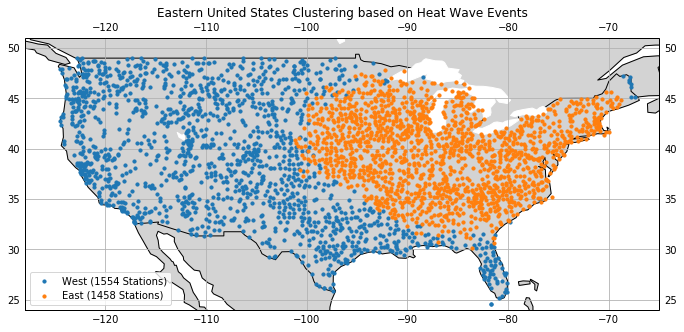

In [6]:
## The region of study is defined by grouping stations together using
## Hierarchical Agglomerative Clustering that minimizes the 
## average intra-cluster Jaccard distance between stations

## The comparison variable is an indicator function of whether or not a station has a
## temperature above the 95th percentile of its peak summer climatology
T95_bool_summer = summer > summer.quantile(0.95)

# Number if Clusters (2 for East/West)
N = 2

# Cluster Weather Station based on T95 (and T95 only)
cluster = KMeans(N)
# cluster = AgglomerativeClustering(N)
# cluster = AgglomerativeClustering(N, affinity="jaccard", linkage="average")
cluster.fit(T95_bool_summer.T)

# Get Latitude, Longitude and Label per Weather Station
lat = ghcn.inventory.loc[df.columns]["LAT"]
lon = ghcn.inventory.loc[df.columns]["LON"]

# Infer East Cluster based on cluster Longitude
cluster_lon = [np.mean(lon[cluster.labels_ == i]) for i in range(N)]
east_index = cluster_lon.index(max(cluster_lon))

# Create Big Figure
plt.rcParams['figure.figsize'] = [15, 5]

# create Projection and Map Elements
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, color="white")
ax.add_feature(cfeature.LAND, color="lightgray")

# Define Map Extends
ax.set_xlim(-128, -65)
ax.set_ylim(24, 51)
ax.gridlines(
    xlocs=range(-180,181, 10),
    ylocs=range(-80,81, 5),
    draw_labels=True)

plt.title("Eastern United States Clustering based on Heat Wave Events\n")

# Plot Cluster Data
for index in range(N):
    label = "East" if index == east_index else "West"
    plt.scatter(lon[cluster.labels_==index],
                lat[cluster.labels_==index],
                transform=projection,
                s=10, zorder=10,
                label=f"{label} ({np.sum(cluster.labels_ == index)} Stations)")

plt.legend()
plt.show()

### East US T95

In [7]:
## To obtain a single quantity representative of both the magnitude and spatial extent of
## high temperatures for each summer day, we calculate the spatial 95th percentile of
## temperature anomalies across the eastern US cluster, referred to as T95 (Data set 1)

east_summer = summer[summer.columns[cluster.labels_ == east_index]]
east_summer_anomaly = east_summer - east_summer.mean()

T95 = east_summer_anomaly.quantile(0.95, 1)

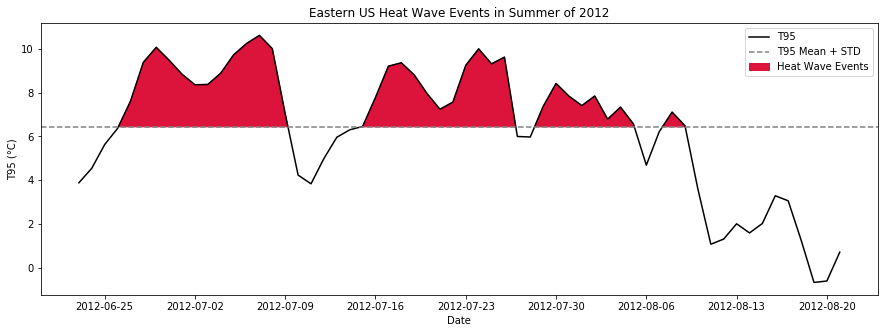

In [11]:
year = "2012"

T95_std = T95.mean() + T95.std()

# Create Big Figure
plt.rcParams['figure.figsize'] = [15, 5]

# Plot T95
plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
plt.plot(T95[year], c="black", label="T95")
plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                 interpolate=True, color="crimson", label="Heat Wave Events")

plt.ylabel("T95 (°C)")
plt.xlabel("Date")
plt.legend()
plt.show()

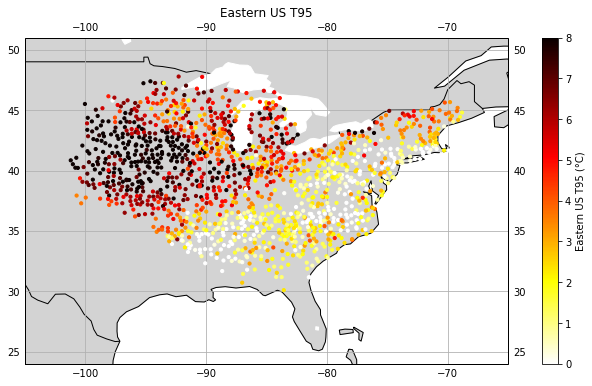

In [10]:
date = "2012-07-23"

lat = ghcn.inventory.loc[east_summer_anomaly.columns]["LAT"]
lon = ghcn.inventory.loc[east_summer_anomaly.columns]["LON"]

# Create Big Figure
plt.rcParams['figure.figsize'] = [12, 6]

# create Projection and Map Elements
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, color="white")
ax.add_feature(cfeature.LAND, color="lightgray")

# Define Map Extends
ax.set_xlim(-105, -65)
ax.set_ylim(24, 51)
ax.gridlines(
    xlocs=range(-180,181, 10),
    ylocs=range(-80,81, 5),
    draw_labels=True)

plt.scatter(lon, lat, c=east_summer_anomaly.loc[date], cmap="hot_r",
            vmin=0, vmax=8, transform=projection, s=10, zorder=10)

plt.title("Eastern US T95\n")
plt.colorbar().ax.set_ylabel("Eastern US T95 (°C)")
    
plt.show()